In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import os
os.chdir('drive/MyDrive/AI Project')

In [11]:
import numpy as np
import matplotlib.pyplot as plt

### Load NPY Files

In [12]:
x_train = np.load('x_train.npy')
x_test = np.load('x_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

In [13]:
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

**Sample Image**

Class: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


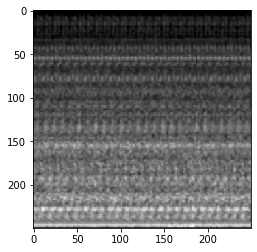

In [6]:
idx = 2500
print(f'Class: {y_train[idx]}')
plt.imshow(x_train[idx].reshape(250,250), cmap = 'gray')

### Building Model

In [14]:
import gc
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam

In [15]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [16]:
def create_model(params):
  """
    create_model creates tf model by given params

    :param params: dictionary of hyperparameters
    :return: tf model
  """ 
  input = Input(shape = (250,250,1))

  for i, filter in enumerate(params['filters']):
    if i == 0:
      conv = Conv2D(filter, params['kernel_size'], 
                    padding = 'same', activation = params['activation'],
                    name = f'block{i}_conv1')(input)
    else:
      conv = Conv2D(filter, params['kernel_size'],
                    padding = 'same', activation = params['activation'],
                    name = f'block{i}_conv1')(batchnorm)

    conv = Conv2D(filter, params['kernel_size'], padding = 'same',
                  activation = params['activation'],
                  name = f'block{i}_conv2')(conv)
    pool = MaxPool2D((2,2), name = f'block{i}_pool1')(conv)
    batchnorm = BatchNormalization(name = f'block{i}_batchnorm1')(pool)

  flatten = Flatten(name = f'block{i}_flatten')(batchnorm)
  dense1 = Dense(128, activation = params['activation'],
                 name = 'dense1')(flatten)
  output = Dense(10, activation = 'softmax', name = 'output')(dense1)

  model = Model(inputs = input, outputs = output)

  return model


### Training Model

In [17]:
BATCH_SIZE = 32 # Yuksek batchlerde RAM yetmiyor :(
EPOCHS = 20 # Hiperparametre aramasi icin 20 sectik
WORKERS = 4

In [18]:
filters = [[32,64,128],[32,64,64,128]]
kernel_size = [(3,3),(5,5)]
activation = ['relu','elu', 'tanh']
optimizers = [SGD, Adam]
search_space = {
    'filters': hp.choice('filters', filters),
    'kernel_size': hp.choice('kernel_size', kernel_size),
    'activation': hp.choice('activation', activation),
    'optimizers': hp.choice('optimizers', optimizers),
    'learning_rate': hp.loguniform('learning_rate', -11, -7),
}

#batch_size eklenebilir

In [19]:
results = []
def objective(params):
  """
    objective function receives a valid point from the search space,
    returns loss value that fmin function tries to minimize.

    :param params: dictionary of hyperparameters
    :return: dictionary of loss and status flag
  """ 

  model = create_model(params)
  model.compile(optimizer = params['optimizers'](learning_rate = params['learning_rate']),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
  model.fit(x_train, y_train, 
          epochs = EPOCHS, batch_size = BATCH_SIZE, 
          validation_split = 0.2, workers = WORKERS, verbose = 0)
  

  result = model.evaluate(x_test, y_test, verbose = 2)
  print(f"Opt: {params['optimizers']}  LR: {params['learning_rate']} Act: {params['activation']}")
  result_dict = {
      'filters': params['filters'],
      'kernel_size': params['kernel_size'],
      'activation': params['activation'],
      'learning_rate': params['learning_rate'],
      'accuracy': result[1],
      'loss': result[0]
  }

  results.append(result_dict)
  gc.collect()
  return {'loss': result[0], 'status': STATUS_OK}

In [20]:
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=15,
    trials=Trials()
)

60/60 - 2s - loss: 0.5857 - accuracy: 0.8196 - 2s/epoch - 34ms/step

Opt: <class 'keras.optimizer_v2.gradient_descent.SGD'>  LR: 0.0003377878266128608 Act: tanh
60/60 - 1s - loss: 0.7165 - accuracy: 0.7729 - 1s/epoch - 21ms/step

Opt: <class 'keras.optimizer_v2.gradient_descent.SGD'>  LR: 0.00010852759168538028 Act: relu
60/60 - 2s - loss: 1.0420 - accuracy: 0.6518 - 2s/epoch - 26ms/step

Opt: <class 'keras.optimizer_v2.gradient_descent.SGD'>  LR: 1.7285221667518076e-05 Act: tanh
60/60 - 1s - loss: 0.7254 - accuracy: 0.7771 - 1s/epoch - 22ms/step

Opt: <class 'keras.optimizer_v2.gradient_descent.SGD'>  LR: 0.0003971898592515029 Act: tanh
60/60 - 2s - loss: 0.5267 - accuracy: 0.8380 - 2s/epoch - 26ms/step

Opt: <class 'keras.optimizer_v2.adam.Adam'>  LR: 1.7077075368835443e-05 Act: tanh
60/60 - 1s - loss: 0.5439 - accuracy: 0.8516 - 962ms/epoch - 16ms/step

Opt: <class 'keras.optimizer_v2.adam.Adam'>  LR: 1.960522373959037e-05 Act: relu
60/60 - 2s - loss: 0.9723 - accuracy: 0.6922 - 2s/

In [21]:
results

[{'filters': (32, 64, 128),
  'kernel_size': (5, 5),
  'activation': 'tanh',
  'learning_rate': 0.0003377878266128608,
  'accuracy': 0.8196119666099548,
  'loss': 0.5856961011886597},
 {'filters': (32, 64, 64, 128),
  'kernel_size': (3, 3),
  'activation': 'relu',
  'learning_rate': 0.00010852759168538028,
  'accuracy': 0.7729417681694031,
  'loss': 0.716526210308075},
 {'filters': (32, 64, 128),
  'kernel_size': (5, 5),
  'activation': 'tanh',
  'learning_rate': 1.7285221667518076e-05,
  'accuracy': 0.6518090963363647,
  'loss': 1.042044758796692},
 {'filters': (32, 64, 64, 128),
  'kernel_size': (3, 3),
  'activation': 'tanh',
  'learning_rate': 0.0003971898592515029,
  'accuracy': 0.7771368622779846,
  'loss': 0.7254146337509155},
 {'filters': (32, 64, 128),
  'kernel_size': (5, 5),
  'activation': 'tanh',
  'learning_rate': 1.7077075368835443e-05,
  'accuracy': 0.8379653692245483,
  'loss': 0.5267082452774048},
 {'filters': (32, 64, 64, 128),
  'kernel_size': (3, 3),
  'activation'

In [22]:
best_result

{'activation': 2,
 'filters': 1,
 'kernel_size': 1,
 'learning_rate': 4.623998518043979e-05,
 'optimizers': 1}

### Train Best Model

In [23]:
best_params = {'activation': 'tanh',
 'filters': [32,64,64,128],
 'kernel_size': (3, 3),
 'learning_rate': 4.623998518043979e-05,
 'optimizers': Adam}

In [26]:
model = create_model(best_params)

model.compile(optimizer = best_params['optimizers'](learning_rate = best_params['learning_rate']),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

history = model.fit(x_train, y_train, 
          epochs = 50, batch_size = BATCH_SIZE, 
          validation_split = 0.2, workers = WORKERS, verbose = 2)

Epoch 1/50
191/191 - 13s - loss: 1.1904 - accuracy: 0.6011 - val_loss: 3.1433 - val_accuracy: 0.1658 - 13s/epoch - 67ms/step
Epoch 2/50
191/191 - 10s - loss: 0.5848 - accuracy: 0.8209 - val_loss: 1.7904 - val_accuracy: 0.5406 - 10s/epoch - 55ms/step
Epoch 3/50
191/191 - 10s - loss: 0.3091 - accuracy: 0.9254 - val_loss: 1.0888 - val_accuracy: 0.6704 - 10s/epoch - 54ms/step
Epoch 4/50
191/191 - 10s - loss: 0.1679 - accuracy: 0.9718 - val_loss: 0.5858 - val_accuracy: 0.8145 - 10s/epoch - 55ms/step
Epoch 5/50
191/191 - 11s - loss: 0.0908 - accuracy: 0.9921 - val_loss: 0.4457 - val_accuracy: 0.8519 - 11s/epoch - 57ms/step
Epoch 6/50
191/191 - 10s - loss: 0.0533 - accuracy: 0.9977 - val_loss: 0.4310 - val_accuracy: 0.8598 - 10s/epoch - 54ms/step
Epoch 7/50
191/191 - 11s - loss: 0.0351 - accuracy: 0.9990 - val_loss: 0.4172 - val_accuracy: 0.8775 - 11s/epoch - 55ms/step
Epoch 8/50
191/191 - 11s - loss: 0.0250 - accuracy: 0.9997 - val_loss: 0.4071 - val_accuracy: 0.8748 - 11s/epoch - 59ms/step


### Print Results

**Train Validation Graphs**

In [29]:
history = history.history

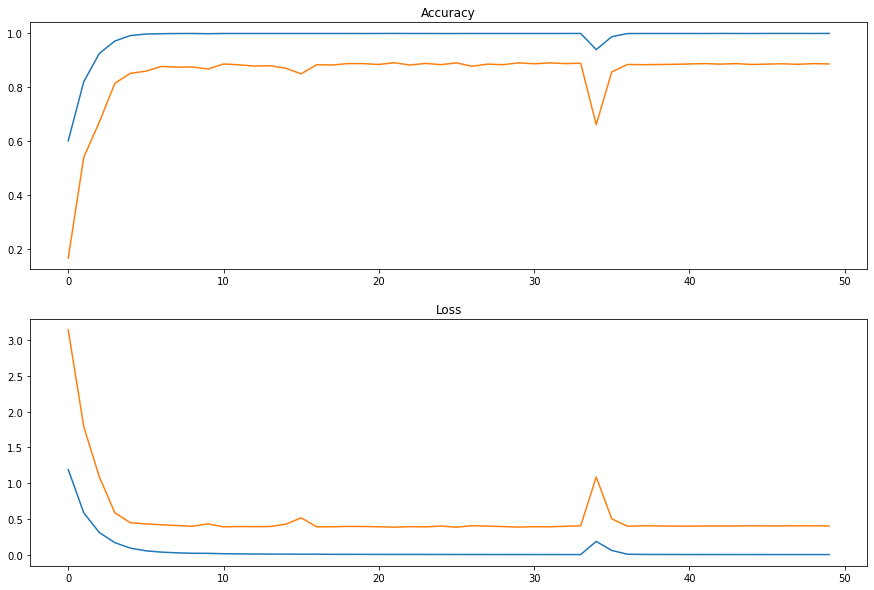

In [30]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (15,10))
ax1.plot(history['accuracy'], label = 'Accuracy')
ax1.plot(history['val_accuracy'], label = 'Val Accuracy')
ax1.set_title('Accuracy')
ax2.plot(history['loss'], label = 'Loss')
ax2.plot(history['val_loss'], label = 'Val Loss')
ax2.set_title('Loss')
fig.show()

**Performance Metrics**

In [31]:
result = model.evaluate(x_test, y_test, verbose = 2)
y_pred = model.predict(x_test)

60/60 - 1s - loss: 0.4769 - accuracy: 0.8663 - 1s/epoch - 19ms/step


In [32]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

In [34]:
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(y_pred, axis=1)

cm = confusion_matrix(max_test, max_predictions)
f1 = f1_score(max_test,max_predictions, average='macro')
precision = precision_score(max_test, max_predictions, average="macro")
recall = recall_score(max_test, max_predictions, average="macro")

print(f"Accuracy: {result[1]}\nF1 Score: {f1}\nPrecision: {precision}\nRecall: {recall}")

Accuracy: 0.8662821054458618
F1 Score: 0.8702771229110035
Precision: 0.8702702403508666
Recall: 0.8710366547578786


**Confusion Matrix**

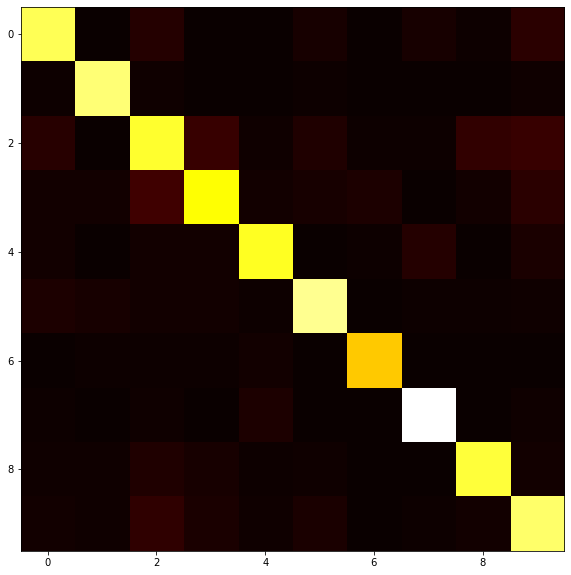

In [36]:
plt.figure(figsize = (10,10))
plt.imshow(cm, cmap='hot', interpolation='nearest')
plt.show()